In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sb
import pickle
from sklearn import metrics
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
sb.set_theme() 
#used to set the seaborn heatmap size

In [2]:
train_data = pd.read_excel("Data_Train.xlsx")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [3]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
train_data.dropna(inplace = True)
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [5]:
train_data["dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour
train_data["dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [6]:
train_data["arrival_hour"] = pd.to_datetime(train_data["Arrival_Time"]).dt.hour
train_data["arrival_min"] = pd.to_datetime(train_data["Arrival_Time"]).dt.minute
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [7]:
train_data["journey_day"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.day
train_data["journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [8]:
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i]

duration_hours = []
duration_mins = []

for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))

train_data["duration_hours"] = duration_hours
train_data["duration_mins"] = duration_mins
train_data.drop(["Duration"], axis = 1, inplace = True)

In [9]:
train_data

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,dep_hour,dep_min,arrival_hour,arrival_min,journey_day,journey_month,duration_hours,duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,22,20,1,10,24,3,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,50,13,15,1,5,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,25,4,25,9,6,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,18,5,23,30,12,5,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,16,50,21,35,1,3,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,non-stop,No info,4107,19,55,22,25,9,4,2,30
10679,Air India,Kolkata,Banglore,CCU → BLR,non-stop,No info,4145,20,45,23,20,27,4,2,35
10680,Jet Airways,Banglore,Delhi,BLR → DEL,non-stop,No info,7229,8,20,11,20,27,4,3,0
10681,Vistara,Banglore,New Delhi,BLR → DEL,non-stop,No info,12648,11,30,14,10,1,3,2,40


Airline vs Price

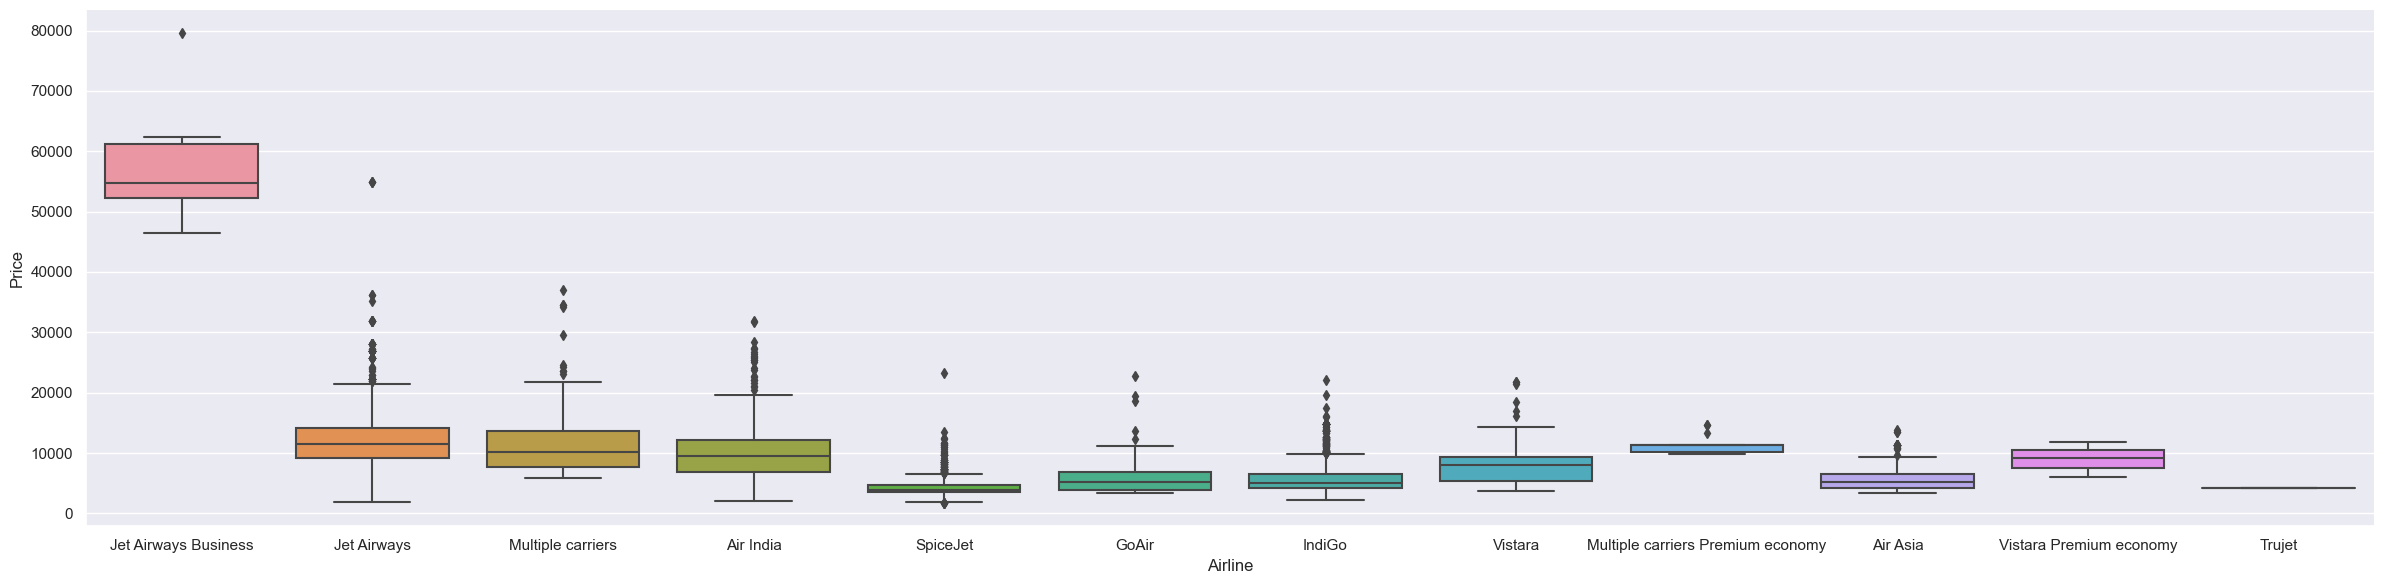

In [10]:
sb.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind = "box", height = 6, aspect = 4)

In [11]:
Airline = train_data[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first = True)

Source vc Price

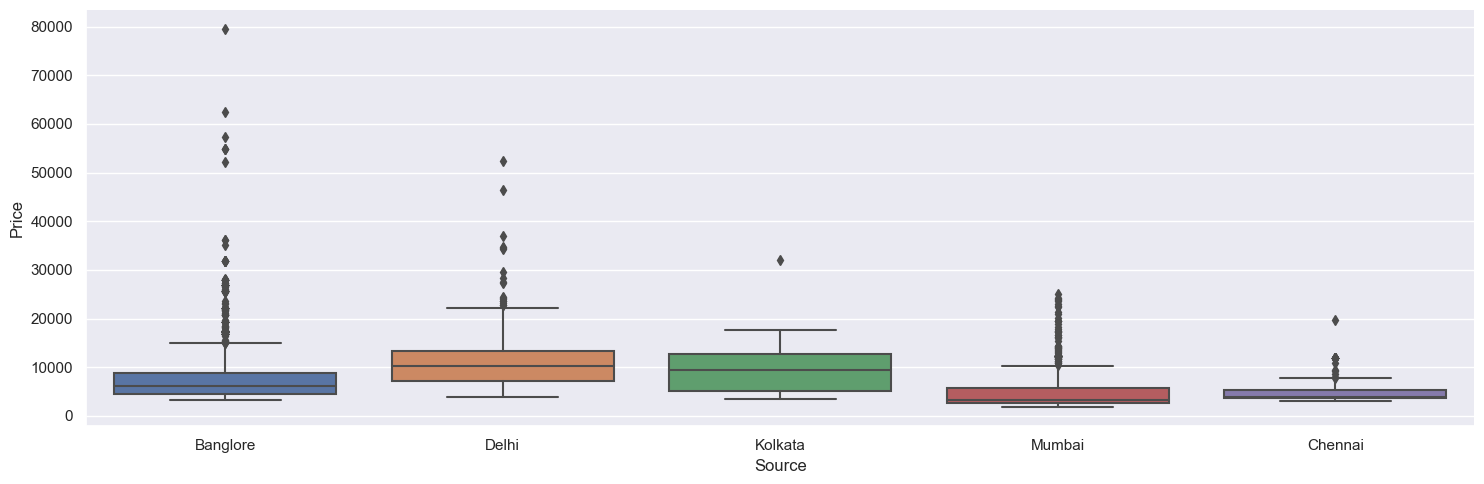

In [12]:
sb.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind = "box", height = 5, aspect = 3)

In [13]:
Source = train_data[["Airline"]]
Source = pd.get_dummies(Source, drop_first = True)

In [14]:
train_data["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [15]:
Destination = train_data[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)

In [16]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [17]:
train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [18]:
train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
train_data

,Airline,Source,Destination,Total_Stops,Price,dep_hour,dep_min,arrival_hour,arrival_min,journey_day,journey_month,duration_hours,duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,22,20,1,10,24,3,2,50
1,Air India,Kolkata,Banglore,2,7662,5,50,13,15,1,5,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,25,4,25,9,6,19,0
3,IndiGo,Kolkata,Banglore,1,6218,18,5,23,30,12,5,5,25
4,IndiGo,Banglore,New Delhi,1,13302,16,50,21,35,1,3,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,0,4107,19,55,22,25,9,4,2,30
10679,Air India,Kolkata,Banglore,0,4145,20,45,23,20,27,4,2,35
10680,Jet Airways,Banglore,Delhi,0,7229,8,20,11,20,27,4,3,0
10681,Vistara,Banglore,New Delhi,0,12648,11,30,14,10,1,3,2,40


In [19]:
data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [20]:
data_train.head()


,Total_Stops,Price,dep_hour,dep_min,arrival_hour,arrival_min,journey_day,journey_month,duration_hours,duration_mins,...,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,22,20,1,10,24,3,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,5,50,13,15,1,5,7,25,...,0,0,0,0,0,0,0,0,0,0
2,2,13882,9,25,4,25,9,6,19,0,...,0,0,0,0,0,1,0,0,0,0
3,1,6218,18,5,23,30,12,5,5,25,...,0,0,0,0,0,0,0,0,0,0
4,1,13302,16,50,21,35,1,3,4,45,...,0,0,0,0,0,0,0,0,0,1


In [21]:
data_train.shape

(10682, 37)

Test

In [22]:
test_data = pd.read_excel("Test_set.xlsx")

In [23]:
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2: 
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m" 
        else:
            duration[i] = "0h " + duration[i]

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))   
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))

test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# categorical data

# nomianl

Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

Source = pd.get_dummies(test_data["Source"], drop_first= True)

Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# ordinal
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [24]:
data_test

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,...,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,6,6,20,30,20,25,23,55,1,...,0,0,0,1,0,0,0,0,0,0
2667,0,27,3,14,20,16,55,2,35,0,...,0,0,0,1,0,0,0,0,0,0
2668,1,6,3,21,50,4,25,6,35,0,...,0,0,1,0,0,1,0,0,0,0
2669,1,6,3,4,0,19,15,15,15,1,...,0,0,1,0,0,1,0,0,0,0


Feature Selection - heatmap, feature_importance, selectKBase

In [25]:
data_train.shape

(10682, 37)

In [26]:
data_train.columns

Index(['Total_Stops', 'Price', 'dep_hour', 'dep_min', 'arrival_hour',
       'arrival_min', 'journey_day', 'journey_month', 'duration_hours',
       'duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [27]:
x = data_train.loc[:,['Total_Stops', 'dep_hour', 'dep_min', 'arrival_hour',
       'arrival_min', 'journey_day', 'journey_month', 'duration_hours',
       'duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]

In [28]:
x.head()

,Total_Stops,dep_hour,dep_min,arrival_hour,arrival_min,journey_day,journey_month,duration_hours,duration_mins,Airline_Air India,...,Airline_Trujet,Airline_Vistara,Airline_Vistara,Airline_Vistara Premium economy,Airline_Vistara Premium economy,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,22,20,1,10,24,3,2,50,0,...,0,0,0,0,0,0,0,0,0,1
1,2,5,50,13,15,1,5,7,25,1,...,0,0,0,0,0,0,0,0,0,0
2,2,9,25,4,25,9,6,19,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,18,5,23,30,12,5,5,25,0,...,0,0,0,0,0,0,0,0,0,0
4,1,16,50,21,35,1,3,4,45,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
y = data_train.iloc[:, 1]

In [30]:
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

C:\Users\vpra\AppData\Local\Temp\ipykernel_17112\1041352121.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")


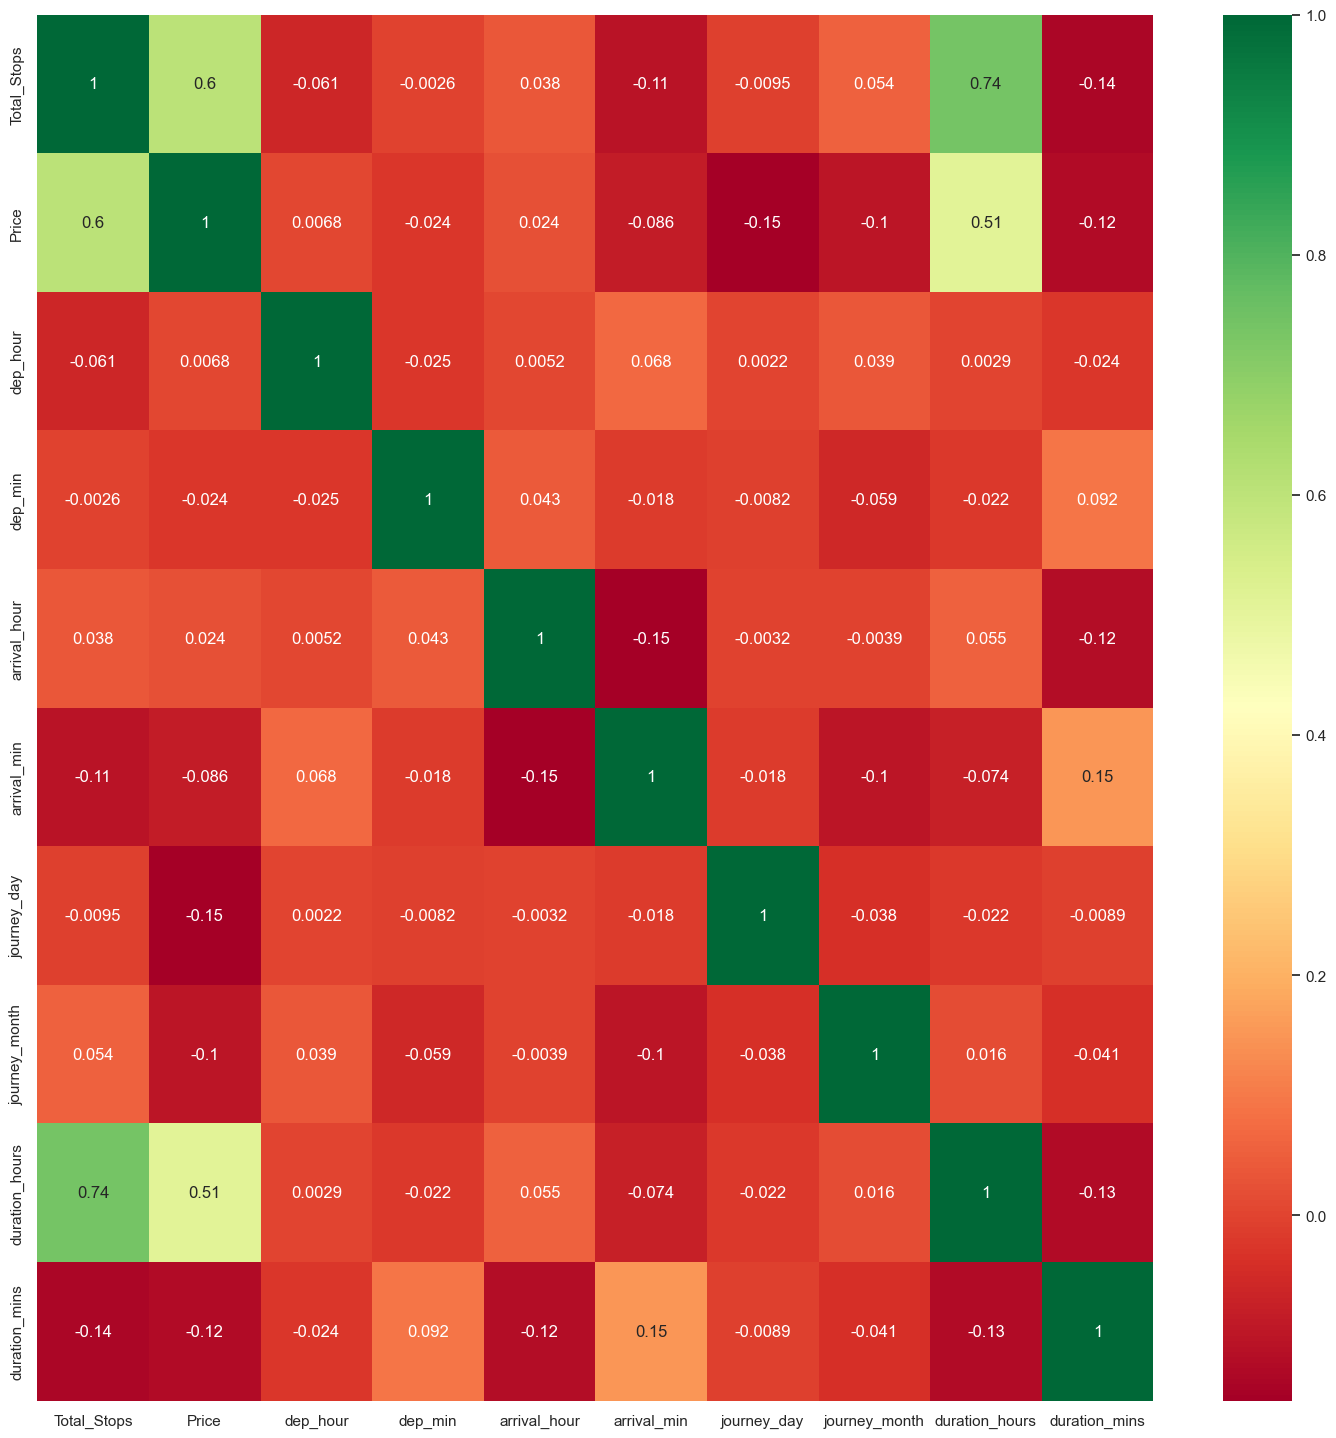

In [31]:
plot.figure(figsize = (18, 18))
sb.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")
plot.show()

In [32]:
selection = ExtraTreesRegressor()
selection.fit(x, y)

ExtraTreesRegressor()

In [33]:
selection.feature_importances_

array([2.29334874e-01, 2.43452941e-02, 2.11277265e-02, 2.70334177e-02,
       1.95672483e-02, 1.43616014e-01, 5.40532465e-02, 1.24532865e-01,
       1.80941331e-02, 5.30413582e-03, 5.01720957e-03, 9.05714935e-04,
       1.19692627e-03, 1.03420620e-02, 6.09239565e-03, 7.71619213e-02,
       5.84034534e-02, 2.92801149e-02, 3.83464038e-02, 1.17887733e-02,
       7.23587061e-03, 4.09236069e-04, 4.39816443e-04, 1.36591819e-03,
       1.65621084e-03, 5.69521981e-05, 6.07709290e-05, 2.77800874e-03,
       2.57357371e-03, 4.00124415e-05, 4.31464774e-05, 2.28861136e-02,
       1.41798469e-02, 1.37654634e-02, 1.02948117e-03, 2.59356489e-02])

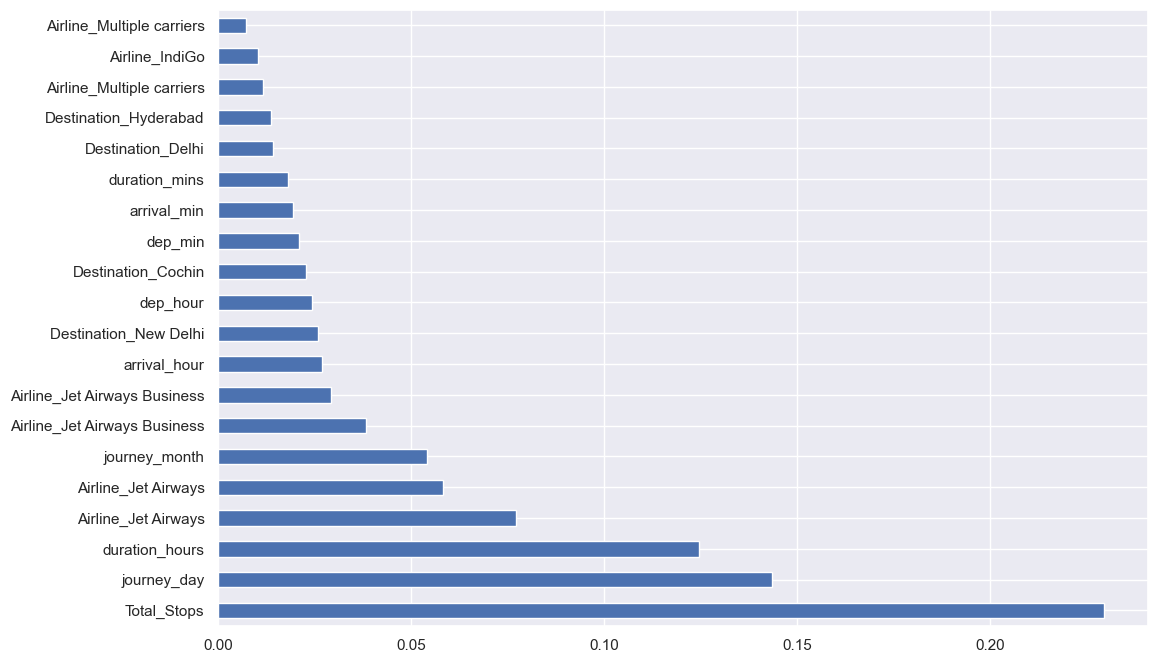

In [34]:
plot.figure(figsize = (12, 8))
feat_importances = pd.Series(selection.feature_importances_, index = x.columns)
feat_importances.nlargest(20).plot(kind = "barh")
plot.show()

Random Forest

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)

RandomForestRegressor()

In [36]:
y_predict = rf_reg.predict(x_test)
rf_reg.score(x_train, y_train)

0.9532924281863155

In [37]:
rf_reg.score(x_test, y_test)

0.796544450977095

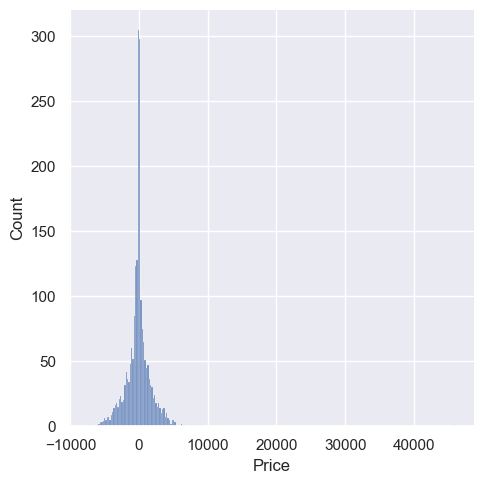

In [38]:
sb.displot(y_test - y_predict)
plot.show()

Text(0, 0.5, 'y_predict')

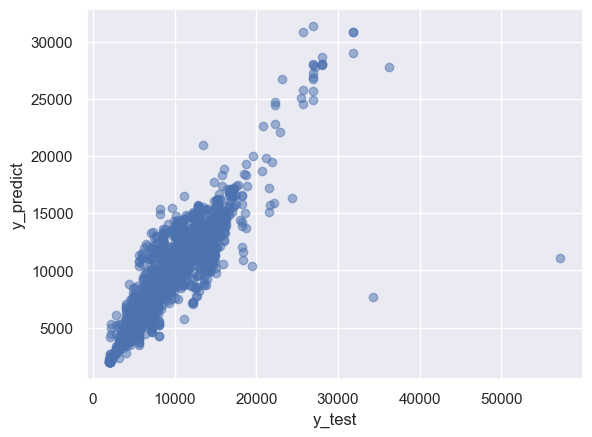

In [39]:
plot.scatter(y_test, y_predict, alpha = 0.5)
plot.xlabel("y_test")
plot.ylabel("y_predict")

In [40]:
print('MAE:', metrics.mean_absolute_error(y_test, y_predict))
print('MSE:', metrics.mean_squared_error(y_test, y_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

MAE: 1183.3712036542854
MSE: 4386920.007495136
RMSE: 2094.497554903117


In [41]:
# RMSE/(max(DV)-min(DV))

2090.5509/(max(y)-min(y))

0.026887077025966846

In [42]:
metrics.r2_score(y_test, y_predict)

0.796544450977095

hyperparameter tuning - randomizedsearchcv, gridsearchcv

In [43]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(5, 30, num =  6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [44]:
random_grid = {"n_estimators": n_estimators,
                "max_features": max_features,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
                "min_samples_leaf": min_samples_leaf}

In [45]:
rf_rand  = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, scoring = "neg_mean_squared_error", n_iter = 10, cv = 5, verbose = 3, n_jobs = -1)
rf_rand.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\vpra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=3)

In [46]:
rf_rand.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30}

In [47]:
prediction = rf_rand.predict(x_test)

<Figure size 800x800 with 0 Axes>

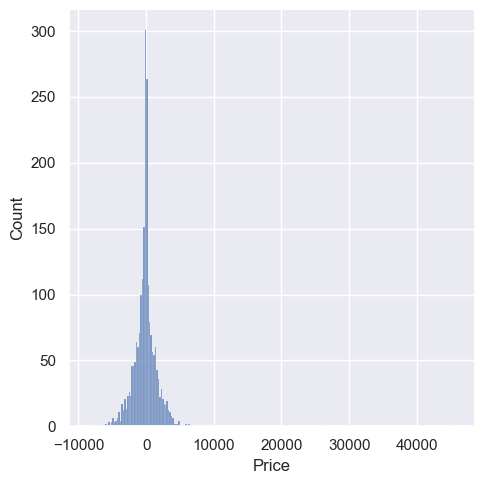

In [48]:
plot.figure(figsize = (8, 8))
sb.displot(y_test - prediction)
plot.show()

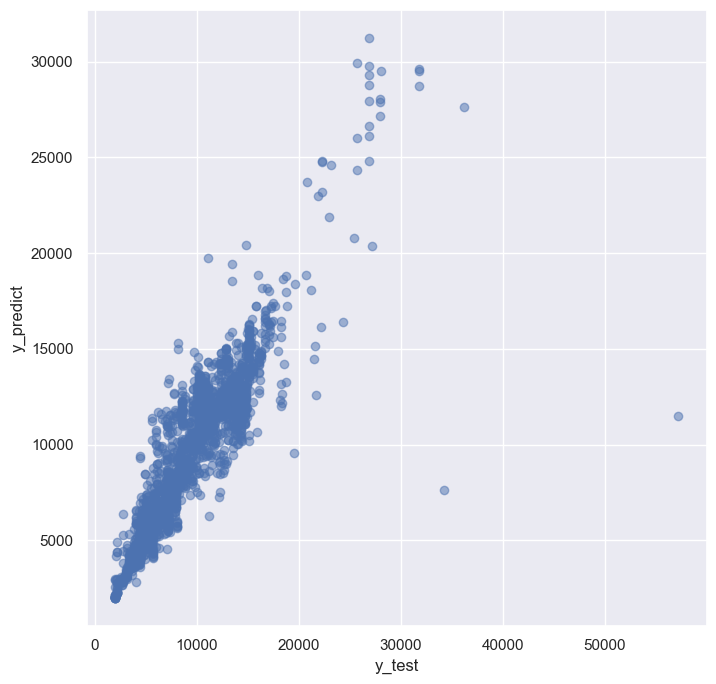

In [49]:
plot.figure(figsize = (8, 8))
plot.scatter(y_test, prediction, alpha = 0.5)
plot.xlabel("y_test")
plot.ylabel("y_predict")
plot.show()

In [50]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1150.4322876758774
MSE: 4056618.0631418517
RMSE: 2014.1047795836869


save

In [51]:
file = open("flight_fare_rf.pkl", "wb")
pickle.dump(rf_rand, file)
file.close()